
# Example of working pipeline

Imports and defining the catalog and database used within databricks

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp, input_file_name, lit
import os

catalog = "ddca_exc4"
database = "default"

Functions for data ingestion (folder path is where the data is read from, in this case wihtin databricks file upload folder)

In [0]:
def ingest_structured_data(file_path, table_name):

    # Structured data
    df = spark.read.format("csv") \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .load(file_path)
    
    # Delta table
    df.write.format("delta") \
        .mode("append") \
        .saveAsTable(f"{catalog}.{database}.{table_name}")
    
    print(f"Structured data from {file_path} ingested into {catalog}.{database}.{table_name}")

In [0]:
def ingest_unstructured_data(file_path, table_name):
    
    # Unsttructured data)
    df = spark.read.format("json") \
        .option("inferSchema", "true") \
        .load(file_path)
    
    # Delta table
    df.write.format("delta") \
        .mode("append") \
        .saveAsTable(f"{catalog}.{database}.{table_name}")
    
    print(f"Unstructured data from {file_path} ingested into {catalog}.{database}.{table_name}")

In [0]:
def ingest_all_files_in_folder(folder_path):

    files = dbutils.fs.ls(folder_path)
    
    for file_info in files:
        file_path = file_info.path
        table_name = os.path.basename(file_path).split(".")[0]
        
        if file_path.endswith(".csv"):
            ingest_structured_data(file_path, table_name)
        elif file_path.endswith(".json"):
            ingest_unstructured_data(file_path, table_name)
        else:
            print(f"Unsupported file format for file: {file_path}")

In [0]:
# Folderpath
folder_path = "/FileStore/tables/f1_data"

ingest_all_files_in_folder(folder_path)

Structured data from dbfs:/FileStore/tables/f1_data/circuits.csv ingested into ddca_exc4.default.circuits
Structured data from dbfs:/FileStore/tables/f1_data/constructor_results.csv ingested into ddca_exc4.default.constructor_results
Structured data from dbfs:/FileStore/tables/f1_data/constructor_standings.csv ingested into ddca_exc4.default.constructor_standings
Structured data from dbfs:/FileStore/tables/f1_data/constructors.csv ingested into ddca_exc4.default.constructors
Structured data from dbfs:/FileStore/tables/f1_data/driver_standings.csv ingested into ddca_exc4.default.driver_standings
Structured data from dbfs:/FileStore/tables/f1_data/drivers.csv ingested into ddca_exc4.default.drivers
Structured data from dbfs:/FileStore/tables/f1_data/lap_times.csv ingested into ddca_exc4.default.lap_times
Structured data from dbfs:/FileStore/tables/f1_data/pit_stops.csv ingested into ddca_exc4.default.pit_stops
Structured data from dbfs:/FileStore/tables/f1_data/qualifying.csv ingested in

Creating bronze layer and importing raw data into it with no modifications

In [0]:
%sql
CREATE SCHEMA IF NOT EXISTS ddca_exc4.bronze;

In [0]:
# Bronze schema
spark.sql("CREATE SCHEMA IF NOT EXISTS ddca_exc4.bronze")

DataFrame[]

In [0]:
spark.sql("CREATE SCHEMA IF NOT EXISTS ddca_exc4.bronze")

def create_bronze_table(raw_table_name, bronze_table_name):
   
    raw_df = spark.sql(f"SELECT * FROM {raw_table_name}")
    
    # Bronze delta table
    raw_df.write.format("delta") \
                .mode("overwrite") \
                .saveAsTable(bronze_table_name)
    
    print(f"Bronze table '{bronze_table_name}' created successfully.")

In [0]:
raw_tables = spark.sql("SHOW TABLES IN ddca_exc4.default").filter("isTemporary == false").select("tableName").rdd.flatMap(lambda x: x).collect()

# Bronze tables
for raw_table in raw_tables:
    raw_table_name = f"ddca_exc4.default.{raw_table}"  
    bronze_table_name = f"ddca_exc4.bronze.{raw_table}" 
    create_bronze_table(raw_table_name, bronze_table_name)

Bronze table 'ddca_exc4.bronze.circuits' created successfully.
Bronze table 'ddca_exc4.bronze.constructor_results' created successfully.
Bronze table 'ddca_exc4.bronze.constructor_standings' created successfully.
Bronze table 'ddca_exc4.bronze.constructors' created successfully.
Bronze table 'ddca_exc4.bronze.driver_standings' created successfully.
Bronze table 'ddca_exc4.bronze.drivers' created successfully.
Bronze table 'ddca_exc4.bronze.lap_times' created successfully.
Bronze table 'ddca_exc4.bronze.pit_stops' created successfully.
Bronze table 'ddca_exc4.bronze.qualifying' created successfully.
Bronze table 'ddca_exc4.bronze.races' created successfully.
Bronze table 'ddca_exc4.bronze.results' created successfully.
Bronze table 'ddca_exc4.bronze.seasons' created successfully.
Bronze table 'ddca_exc4.bronze.sprint_results' created successfully.
Bronze table 'ddca_exc4.bronze.status' created successfully.


Creating silver layer

In [0]:
%sql
CREATE SCHEMA IF NOT EXISTS ddca_exc4.bronze;

In [0]:
# Bronze schema
spark.sql("CREATE SCHEMA IF NOT EXISTS ddca_exc4.bronze")

DataFrame[]

Handling null values, standardazing column names, deduplication and adding metadata columns

In [0]:
from pyspark.sql.functions import col, current_timestamp, lit, when
from pyspark.sql import DataFrame

def handle_null_values(df: DataFrame, table_name: str) -> DataFrame:

    #Null values
    for column in df.columns:
        if column == "position" and table_name in ["results", "qualifying"]:
            # Replace both NULL and '\\N' with 'DNF' for position column
            df = df.withColumn(column, when(col(column).isNull() | (col(column) == lit("\\N")), lit("DNF")).otherwise(col(column)))
        else:
            df = df.withColumn(column, when(col(column).isNull(), lit("Unknown")).otherwise(col(column)))
    
    return df

def create_silver_table(bronze_table_name, silver_table_name, primary_keys):
    
    #Silver table
    table_name = bronze_table_name.split(".")[-1]

    bronze_df = spark.read.format("delta").table(bronze_table_name)

    bronze_df = handle_null_values(bronze_df, table_name)

    # Standardizing column names by making them lower case
    silver_df = bronze_df.select([col(c).alias(c.lower()) for c in bronze_df.columns])

    # Deduplication based on primary keys
    if primary_keys:
        silver_df = silver_df.dropDuplicates(primary_keys)

    # Adding metadata columns
    silver_df = silver_df.withColumn("processed_date", current_timestamp()) \
                         .withColumn("is_valid", lit(True))

    # Silver delta table
    silver_df.write.format("delta").mode("overwrite").saveAsTable(silver_table_name)

    print(f"Silver table '{silver_table_name}' created successfully.")

bronze_schema = "ddca_exc4.bronze"
silver_schema = "ddca_exc4.silver"

tables_primary_keys = {
    "circuits": ["circuitid"],
    "constructor_standings": ["constructorstandingsid", "raceid", "constructorid"],
    "constructors": ["constructorid"],
    "driver_standings": ["driverstandingsid", "raceid", "driverid"],
    "drivers": ["driverid"],
    "lap_times": ["raceid", "driverid", "lap"],
    "pit_stops": ["raceid", "driverid", "stop", "lap"],
    "qualifying": ["qualifyid"],
    "races": ["raceid"],
    "results": ["resultid"],
    "seasons": ["year"],
    "sprint_results": ["resultid"],
    "status": ["statusid"]
}

# Processing tables
for table, primary_keys in tables_primary_keys.items():
    bronze_table_name = f"{bronze_schema}.{table}"
    silver_table_name = f"{silver_schema}.{table}"
    create_silver_table(bronze_table_name, silver_table_name, primary_keys)

Silver table 'ddca_exc4.silver.circuits' created successfully.
Silver table 'ddca_exc4.silver.constructor_standings' created successfully.
Silver table 'ddca_exc4.silver.constructors' created successfully.
Silver table 'ddca_exc4.silver.driver_standings' created successfully.
Silver table 'ddca_exc4.silver.drivers' created successfully.
Silver table 'ddca_exc4.silver.lap_times' created successfully.
Silver table 'ddca_exc4.silver.pit_stops' created successfully.
Silver table 'ddca_exc4.silver.qualifying' created successfully.
Silver table 'ddca_exc4.silver.races' created successfully.
Silver table 'ddca_exc4.silver.results' created successfully.
Silver table 'ddca_exc4.silver.seasons' created successfully.
Silver table 'ddca_exc4.silver.sprint_results' created successfully.
Silver table 'ddca_exc4.silver.status' created successfully.


Creating gold layer

In [0]:
%sql
CREATE SCHEMA IF NOT EXISTS ddca_exc4.gold;

In [0]:
# Gold schema
spark.sql("CREATE SCHEMA IF NOT EXISTS ddca_exc4.gold")

DataFrame[]

Joining relevant columns to create one table for race results by date with proper data

In [0]:
from pyspark.sql import functions as F

def create_race_results_by_date():
    
    # Golden Layer table: race results by date.
    
    # Relevant tables
    results_df = spark.read.format("delta").table("ddca_exc4.silver.results")
    drivers_df = spark.read.format("delta").table("ddca_exc4.silver.drivers")
    constructors_df = spark.read.format("delta").table("ddca_exc4.silver.constructors")
    races_df = spark.read.format("delta").table("ddca_exc4.silver.races")
    circuits_df = spark.read.format("delta").table("ddca_exc4.silver.circuits")
    qualifying_df = spark.read.format("delta").table("ddca_exc4.silver.qualifying")

    # Position columns
    results_df = results_df.withColumn("race_position", F.col("position"))
    qualifying_df = qualifying_df.withColumn("qualifying_position", F.col("position"))

    # Handling conflicting columns
    drivers_df = drivers_df.select(
        "driverid",
        F.col("forename").alias("driver_forename"),
        F.col("surname").alias("driver_surname"),
        F.col("nationality").alias("driver_nationality")
    )

    constructors_df = constructors_df.select(
        "constructorid",
        F.col("name").alias("constructor_name"),
        F.col("nationality").alias("constructor_nationality")
    )

    races_df = races_df.select(
        "raceid", "circuitid", "date", 
        F.col("name").alias("race_name")
    )

    circuits_df = circuits_df.select(
        "circuitid",
        F.col("name").alias("circuit_name"),
        F.col("location").alias("circuit_location"),
        F.col("country").alias("circuit_country")
    )

    qualifying_df = qualifying_df.select(
        "raceid", "driverid", "qualifying_position"
    )

    # Joining tables and replacing new null values with "Unknown" where necessary
    race_results_df = results_df \
        .join(drivers_df, "driverid", "inner") \
        .join(constructors_df, "constructorid", "inner") \
        .join(races_df, "raceid", "inner") \
        .join(circuits_df, "circuitid", "inner") \
        .join(qualifying_df, ["raceid", "driverid"], "left") \
        .select(
            "date",
            "race_name",
            "circuit_name",
            "circuit_location",
            "circuit_country",
            F.coalesce("driver_forename", F.lit("Unknown")).alias("driver_forename"),
            F.coalesce("driver_surname", F.lit("Unknown")).alias("driver_surname"),
            F.coalesce("driver_nationality", F.lit("Unknown")).alias("driver_nationality"),
            F.coalesce("constructor_name", F.lit("Unknown")).alias("constructor_name"),
            F.coalesce("constructor_nationality", F.lit("Unknown")).alias("constructor_nationality"),
            F.coalesce("race_position", F.lit("Unknown")).alias("race_position"),
            F.coalesce("qualifying_position", F.lit("Unknown")).alias("qualifying_position")
        ) \
        .orderBy("date")

    # Golden delta table
    race_results_df.write.format("delta").mode("overwrite").saveAsTable("ddca_exc4.gold.race_results_by_date")

    print("Golden table 'ddca_exc4.gold.race_results_by_date' created successfully.")


create_race_results_by_date()

Golden table 'ddca_exc4.gold.race_results_by_date' created successfully.


# Unit tests on pipeline

In [0]:
def test_catalog_and_schemas_exist():
    """Test that the catalog and all layer schemas exist"""
    print("=== Testing Catalog and Schemas ===")
    
    # Checking for catalog
    catalogs = spark.sql("SHOW CATALOGS").select("catalog").rdd.flatMap(lambda x: x).collect()
    assert "ddca_exc4" in catalogs, f"Catalog 'ddca_exc4' not found. Available catalogs: {catalogs}"
    print("✅ Catalog 'ddca_exc4' exists")
    
    # Checking schemas
    required_schemas = ["bronze", "silver", "gold"]
    existing_schemas = spark.sql("SHOW SCHEMAS IN ddca_exc4").select("databaseName").rdd.flatMap(lambda x: x).collect()
    
    missing_schemas = [s for s in required_schemas if s not in existing_schemas]
    if missing_schemas:
        print(f"Existing schemas in ddca_exc4: {existing_schemas}")
        assert False, f"Missing schemas in ddca_exc4 catalog: {missing_schemas}"
    
    print("✅ All layer schemas exist in ddca_exc4 catalog")
    return True

def test_tables_created():
    """Test that tables exist in each layer"""
    print("\n=== Testing Table Creation ===")
    
    # Getting expected tables from primary keys dictionary
    expected_tables = list(tables_primary_keys.keys())
    
    # Checking bronze layer tables
    bronze_tables = spark.sql("SHOW TABLES IN ddca_exc4.bronze").select("tableName").rdd.flatMap(lambda x: x).collect()
    missing_bronze = [t for t in expected_tables if t not in bronze_tables]
    assert not missing_bronze, f"Missing tables in bronze layer: {missing_bronze}"
    print("✅ All expected tables exist in bronze layer")
    
    # Checking silver layer tables
    silver_tables = spark.sql("SHOW TABLES IN ddca_exc4.silver").select("tableName").rdd.flatMap(lambda x: x).collect()
    missing_silver = [t for t in expected_tables if t not in silver_tables]
    assert not missing_silver, f"Missing tables in silver layer: {missing_silver}"
    print("✅ All expected tables exist in silver layer")
    
    # Checking gold layer table
    gold_tables = spark.sql("SHOW TABLES IN ddca_exc4.gold").select("tableName").rdd.flatMap(lambda x: x).collect()
    assert "race_results_by_date" in gold_tables, "race_results_by_date missing in gold layer"
    print("✅ Gold table exists")

def test_silver_transformations():
    """Test that silver layer transformations were applied correctly"""
    print("\n=== Testing Silver Layer Transformations ===")
    
    for table in tables_primary_keys.keys():
        silver_df = spark.table(f"ddca_exc4.silver.{table}")
        
        # Checking null handling
        null_counts = {col: silver_df.filter(silver_df[col].isNull()).count() 
                      for col in silver_df.columns}
        problematic_cols = {col: cnt for col, cnt in null_counts.items() if cnt > 0}
        assert not problematic_cols, f"Null values found in {table}: {problematic_cols}"
        
        # Checking for metadata columns
        if "processed_date" not in silver_df.columns:
            print(f"ℹ️ Table {table} missing processed_date column")
        if "is_valid" not in silver_df.columns:
            print(f"ℹ️ Table {table} missing is_valid column")
    
    print("✅ Silver layer transformations validated")

def test_gold_table():
    """Test that gold table was created correctly"""
    print("\n=== Testing Gold Layer ===")
    
    gold_df = spark.table("ddca_exc4.gold.race_results_by_date")
    
    # Checking required columns
    required_columns = {
        "date", "race_name", "circuit_name", "circuit_location", 
        "circuit_country", "driver_forename", "driver_surname",
        "driver_nationality", "constructor_name", "constructor_nationality",
        "race_position", "qualifying_position"
    }
    missing_cols = required_columns - set(gold_df.columns)
    assert not missing_cols, f"Missing columns in gold table: {missing_cols}"
    
    # Checking correct data ordering
    dates = [row.date for row in gold_df.select("date").collect()]
    assert dates == sorted(dates), "Gold table not ordered by date"
    
    print("✅ Gold layer table validated")

def run_pipeline_tests():
    """Main function to run all tests"""
    try:
        print("Starting Data Pipeline Tests\n")
        
        # First testing catalog and schemas
        if not test_catalog_and_schemas_exist():
            return
            
        # Running remaining tests
        test_tables_created()
        test_silver_transformations()
        test_gold_table()
        
        print("\n All pipeline tests passed successfully!")
    except Exception as e:
        print(f"\n❌ Test failed: {str(e)}")
        print("Check the pipeline execution and try again")
        raise

run_pipeline_tests()

Starting Data Pipeline Tests

=== Testing Catalog and Schemas ===
✅ Catalog 'ddca_exc4' exists
✅ All layer schemas exist in ddca_exc4 catalog

=== Testing Table Creation ===
✅ All expected tables exist in bronze layer
✅ All expected tables exist in silver layer
✅ Gold table exists

=== Testing Silver Layer Transformations ===
✅ Silver layer transformations validated

=== Testing Gold Layer ===
✅ Gold layer table validated

 All pipeline tests passed successfully!


# Visualizations

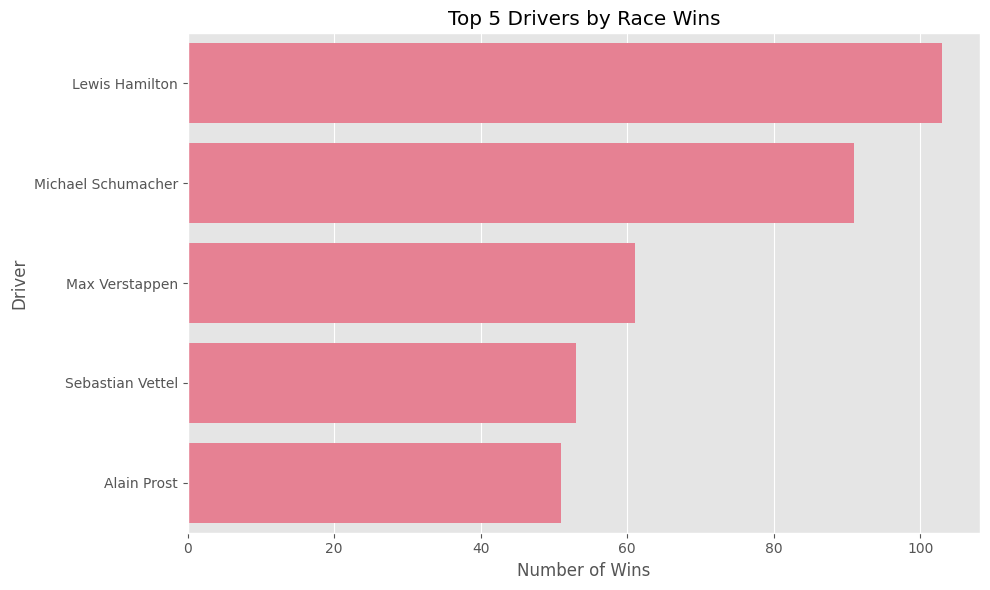

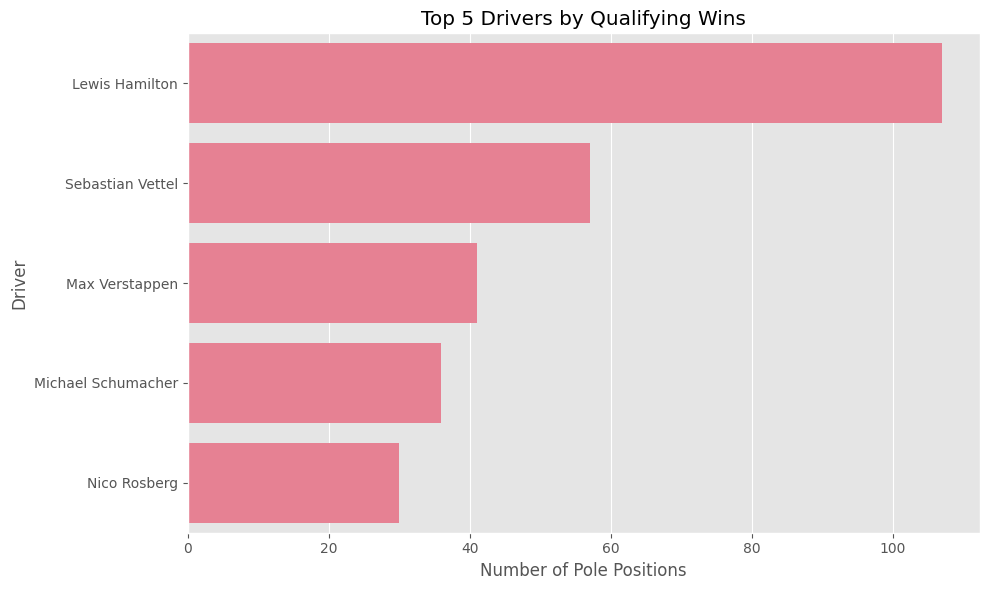

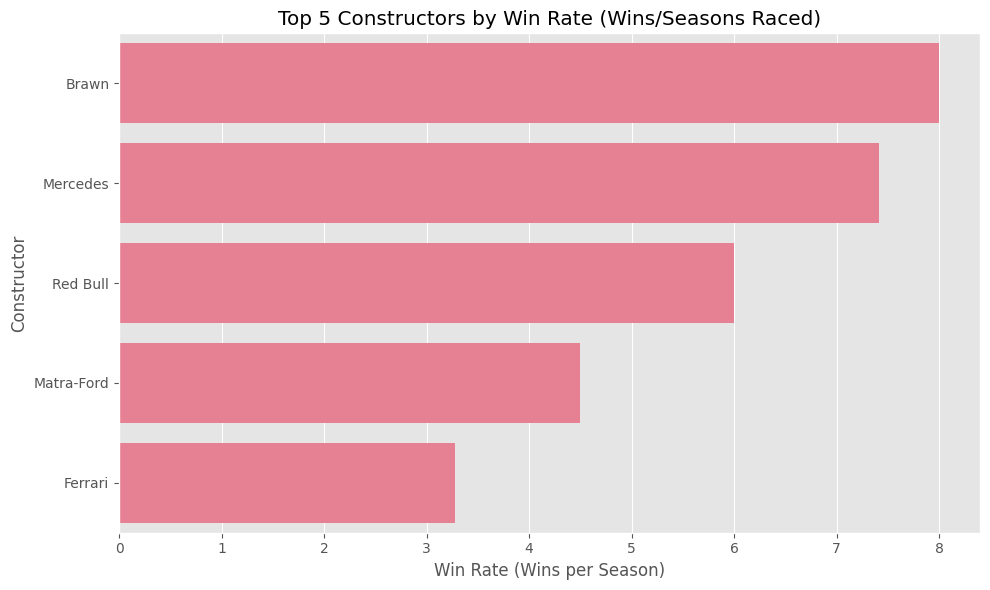

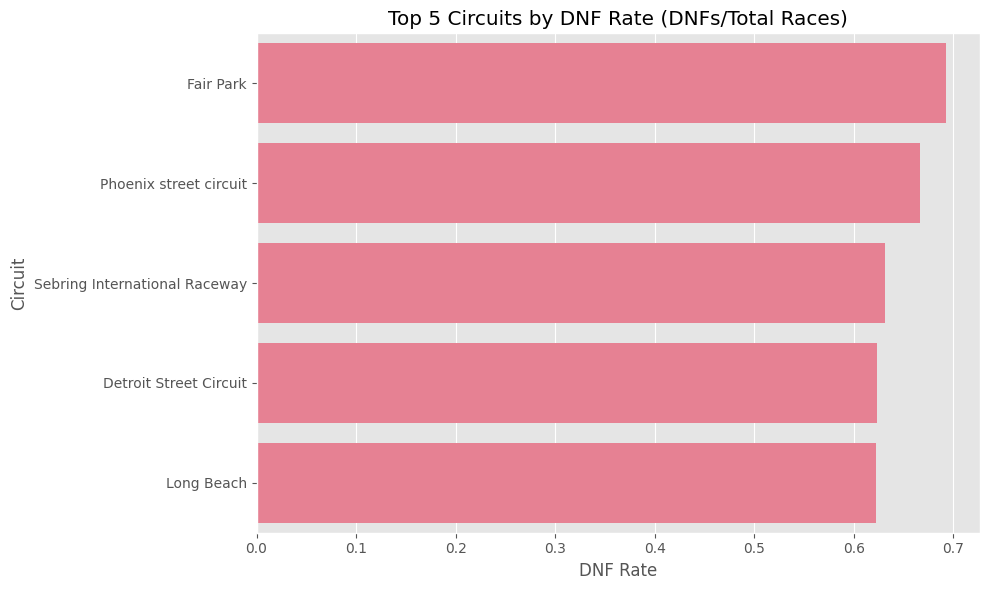

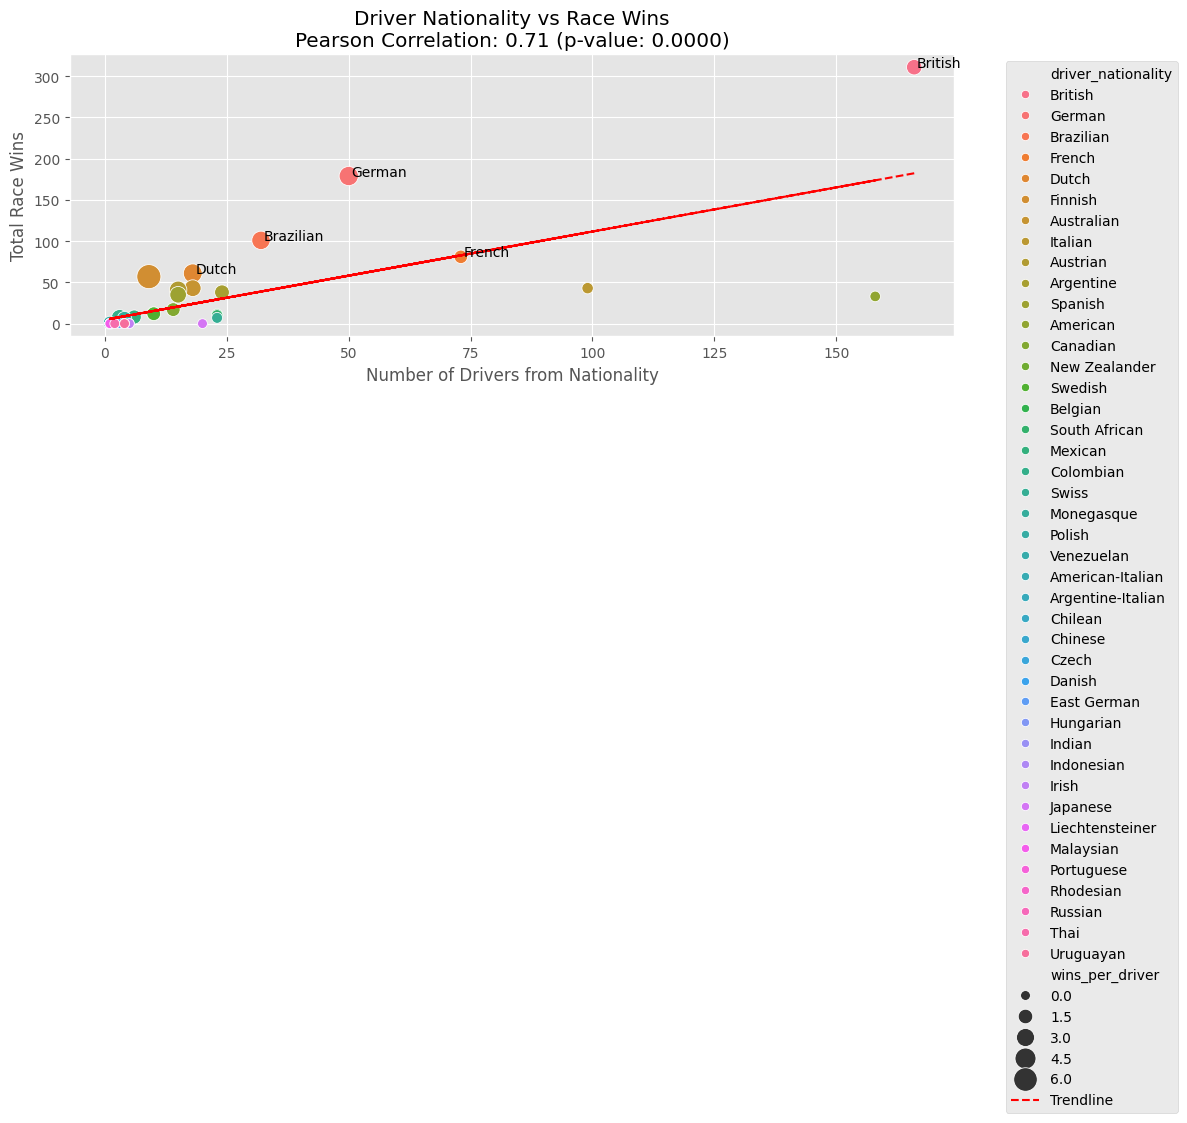

Correlation Interpretation:
Pearson Correlation: 0.71
p-value: 0.0000
Interpretation: Strong relationship


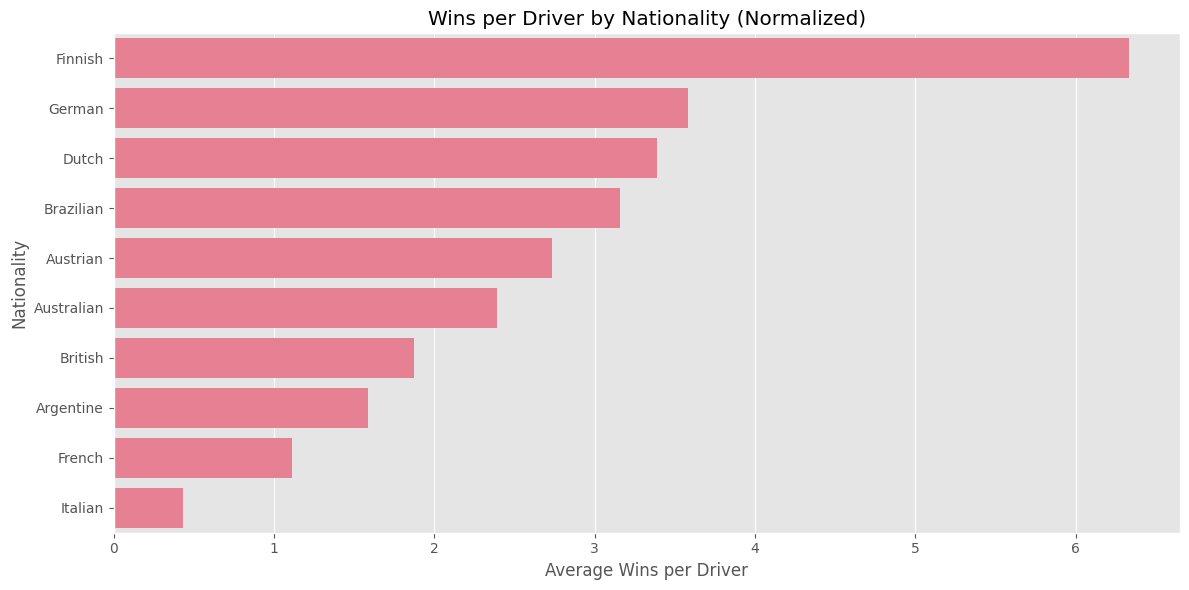

driver_nationality,wins,driver_count,wins_per_driver
British,311,166,1.8734939759036144
German,179,50,3.58
Brazilian,101,32,3.15625
French,81,73,1.1095890410958904
Dutch,61,18,3.388888888888889
Finnish,57,9,6.333333333333333
Australian,43,18,2.388888888888889
Italian,43,99,0.43434343434343436
Austrian,41,15,2.7333333333333334
Argentine,38,24,1.5833333333333333


driver_nationality,wins,total_drivers,wins_per_driver
Finnish,57,9,6.333333333333333
German,179,50,3.58
Dutch,61,18,3.388888888888889
Brazilian,101,32,3.15625
Austrian,41,15,2.7333333333333334
Australian,43,18,2.388888888888889
British,311,166,1.8734939759036144
Argentine,38,24,1.5833333333333333
French,81,73,1.1095890410958904
Italian,43,99,0.43434343434343436


In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

plt.style.use('ggplot')
sns.set_palette("husl")

race_results = spark.table("ddca_exc4.gold.race_results_by_date")

# 1. Top 5 Drivers by Race Wins
driver_wins = (race_results
    .filter(F.col("race_position") == "1")
    .groupBy("driver_forename", "driver_surname")
    .agg(F.count("*").alias("wins"))
    .orderBy(F.desc("wins"))
    .limit(5)
    .toPandas())

driver_wins["driver_name"] = driver_wins["driver_forename"] + " " + driver_wins["driver_surname"]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="wins", y="driver_name", data=driver_wins, ax=ax)
ax.set_title("Top 5 Drivers by Race Wins")
ax.set_xlabel("Number of Wins")
ax.set_ylabel("Driver")
plt.tight_layout()
display(fig)
plt.close(fig)

# 2. Top 5 Drivers by Qualifying Wins
qualifying_wins = (race_results
    .filter(F.col("qualifying_position") == "1")
    .groupBy("driver_forename", "driver_surname")
    .agg(F.count("*").alias("qualifying_wins"))
    .orderBy(F.desc("qualifying_wins"))
    .limit(5)
    .toPandas())

qualifying_wins["driver_name"] = qualifying_wins["driver_forename"] + " " + qualifying_wins["driver_surname"]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="qualifying_wins", y="driver_name", data=qualifying_wins, ax=ax)
ax.set_title("Top 5 Drivers by Qualifying Wins")
ax.set_xlabel("Number of Pole Positions")
ax.set_ylabel("Driver")
plt.tight_layout()
display(fig)
plt.close(fig)

# 3. Top 5 Constructors by Win Rate
constructor_stats = (race_results
    .groupBy("constructor_name")
    .agg(
        F.countDistinct(F.year("date")).alias("seasons_raced"),
        F.sum(F.when(F.col("race_position") == "1", 1).otherwise(0)).alias("wins")
    )
    .withColumn("win_rate", F.col("wins") / F.col("seasons_raced"))
    .orderBy(F.desc("win_rate"))
    .limit(5)
    .toPandas())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="win_rate", y="constructor_name", data=constructor_stats, ax=ax)
ax.set_title("Top 5 Constructors by Win Rate (Wins/Seasons Raced)")
ax.set_xlabel("Win Rate (Wins per Season)")
ax.set_ylabel("Constructor")
plt.tight_layout()
display(fig)
plt.close(fig)

# 4. Top 5 Circuits by DNF Rate
circuit_dnf_stats = (race_results
    .groupBy("circuit_name")
    .agg(
        F.count("*").alias("total_races"),
        F.sum(F.when(F.col("race_position") == "DNF", 1).otherwise(0)).alias("dnfs")
    )
    .withColumn("dnf_rate", F.col("dnfs") / F.col("total_races"))
    .orderBy(F.desc("dnf_rate"))
    .limit(5)
    .toPandas())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="dnf_rate", y="circuit_name", data=circuit_dnf_stats, ax=ax)
ax.set_title("Top 5 Circuits by DNF Rate (DNFs/Total Races)")
ax.set_xlabel("DNF Rate")
ax.set_ylabel("Circuit")
plt.tight_layout()
display(fig)
plt.close(fig)

# 5. Correlation Between Driver Nationality and Race Wins
def interpret_correlation(r):
    """Interpret correlation coefficient strength"""
    abs_r = abs(r)
    if abs_r >= 0.8:
        return "Very strong relationship"
    elif abs_r >= 0.6:
        return "Strong relationship"
    elif abs_r >= 0.4:
        return "Moderate relationship"
    elif abs_r >= 0.2:
        return "Weak relationship"
    else:
        return "Very weak or no relationship"

nationality_stats = (race_results
    .filter(F.col("race_position") == "1")
    .groupBy("driver_nationality")
    .agg(F.count("*").alias("wins"))
    .join(
        race_results.groupBy("driver_nationality")
                   .agg(F.countDistinct(F.concat("driver_forename", "driver_surname")).alias("driver_count")),
        on="driver_nationality",
        how="outer"
    )
    .fillna(0)
    .orderBy(F.desc("wins"))
    .toPandas())

nationality_stats["wins_per_driver"] = nationality_stats["wins"] / nationality_stats["driver_count"]
nationality_stats = nationality_stats[nationality_stats["driver_count"] > 0]

corr, p_value = pearsonr(nationality_stats["driver_count"], nationality_stats["wins"])

fig, ax = plt.subplots(figsize=(12, 8))
scatter = sns.scatterplot(
    x="driver_count", 
    y="wins", 
    size="wins_per_driver",
    sizes=(50, 300),
    hue="driver_nationality",
    data=nationality_stats,
    ax=ax,
    legend="brief"
)

ax.set_title(f"Driver Nationality vs Race Wins\nPearson Correlation: {corr:.2f} (p-value: {p_value:.4f})")
ax.set_xlabel("Number of Drivers from Nationality")
ax.set_ylabel("Total Race Wins")
ax.grid(True)

top_nationalities = nationality_stats.nlargest(5, "wins")
for _, row in top_nationalities.iterrows():
    ax.text(
        row["driver_count"] + 0.5, 
        row["wins"] + 0.5, 
        row["driver_nationality"],
        fontsize=10,
        ha='left'
    )

z = np.polyfit(nationality_stats["driver_count"], nationality_stats["wins"], 1)
p = np.poly1d(z)
plt.plot(
    nationality_stats["driver_count"], 
    p(nationality_stats["driver_count"]), 
    "r--",
    label="Trendline"
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
display(fig)
plt.close(fig)

print("Correlation Interpretation:")
print(f"Pearson Correlation: {corr:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Interpretation: {interpret_correlation(corr)}")

# 6. Wins per Nationality Normalized by Driver Count
nationality_wins = (race_results
    .filter(F.col("race_position") == "1")
    .groupBy("driver_nationality")
    .agg(F.count("*").alias("wins"))
    .orderBy(F.desc("wins"))
    .limit(10)
    .toPandas())

total_drivers = (race_results
    .groupBy("driver_nationality")
    .agg(F.countDistinct(F.concat("driver_forename", "driver_surname")).alias("total_drivers"))
    .toPandas())

nationality_stats_normalized = pd.merge(
    nationality_wins,
    total_drivers,
    on="driver_nationality",
    how="left"
).fillna(0)

nationality_stats_normalized["wins_per_driver"] = nationality_stats_normalized["wins"] / nationality_stats_normalized["total_drivers"]

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x="wins_per_driver", 
    y="driver_nationality", 
    data=nationality_stats_normalized.sort_values("wins_per_driver", ascending=False),
    ax=ax
)
ax.set_title("Wins per Driver by Nationality (Normalized)")
ax.set_xlabel("Average Wins per Driver")
ax.set_ylabel("Nationality")
plt.tight_layout()
display(fig)
plt.close(fig)

display(nationality_stats.sort_values("wins", ascending=False))
display(nationality_stats_normalized.sort_values("wins_per_driver", ascending=False))